# Montamos el drive e importamos librerias

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import pandas as pd
!pip install pandas_summary
from pandas_summary import DataFrameSummary
import numpy as np
import datetime
!pip install isoweek
from isoweek import Week
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
!pip install sklearn_pandas
from sklearn_pandas import DataFrameMapper
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

# Para importar el Helper
%cd "/gdrive/Shareddrives/Redes neuronales/TP2"
!pip install import-ipynb
import import_ipynb
from Helper import *

/gdrive/Shareddrives/Redes neuronales/TP2
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=9b905b1f4675f8a8dc13680deffdd30a01812512074a047e5ec2bee897d68506
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb
importing Jupyter notebook from Helper.ipynb


# Analisis de los embeddings

## Cargamos los datos y dividimos en train y val

In [3]:
df = pd.read_feather('data preprecesada/train_normalized_data_!sales0.fth')
df_test = pd.read_feather('data preprecesada/test_normalized_data.fth')

In [4]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]

# Analisis de embeddings

Levantamos el modelo generado en TP2-Modelo

In [5]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw',
            'Close_bool_bw','Close_bool_fw']


contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']

cat_var_dict = {'Store': 50, 'DayOfWeek': 3, 'Year': 3, 'Month': 4,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 4,
'Promo2Weeks': 3, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 4,
'Week': 4, 'Events': 7, 'Promo_fw': 4,
'Promo_bw': 4, 'StateHoliday_bool_fw': 2,
'StateHoliday_bool_bw': 2, 'SchoolHoliday_fw': 2,
'SchoolHoliday_bw': 2,'Close_bool_bw':3,'Close_bool_fw':3}

uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]


cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [6]:
# Parametros de entrada para creación de las capas ocultas:
cant_capas_ocultas = 2
cantidad_neuronas = [1000, 500]
l2_lambda = 1e-3
activation_function = ["relu","relu"]
alpha = [0, 0] # Se puede cambiar el valor de alpha en caso de usar función LeakyRelu.
# Recordar que el alpha tiene que ser un vector
kernel_initializer = "uniform"

In [8]:
concatenate_layer = MLP_layers(cat_vars_embed_outs, cont_vars_inputs, l2_lambda, kernel_initializer, cant_capas_ocultas, cant_neuronas= cantidad_neuronas, activation_func= activation_function)
model = crear_MLP(True, cat_var_inputs, cont_vars_inputs, concatenate_layer, 'linear')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Year_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_input (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

## Se plotean los embeddings

En *cat_var_dict* se definen la cantidad de grupos por embedding que se decidieron hacer. Para tomar esta decicisión se fueron probando diferentes valores y se dejaron los que parecian separar de una forma lógica los valores.  

Los datos que tienen un contexto similar se colocan cerca unos de otros, mientras que los que tienen un contexto diferente se colocan más separados. 

A continuación se van ploteando los embeddings para cada variable categorica


### DayOfWeek embedding

Se hacen 3 grupos

(7, 3)


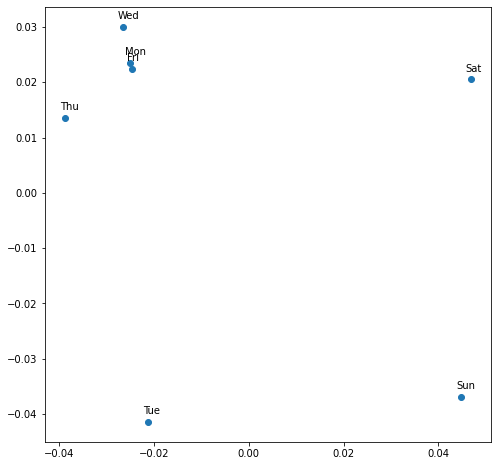

In [ ]:
plot_embed(model,'DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

En este caso se puede notar que los días lunes, miércoles, jueves y viernes presentan un comportamiento parecido, por otro lado los sabados y domingo presentan otro comportamiento y los martes conforman el tercer grupo.

### StateHoliday_Embed

Se hacen 3 grupos

(4, 3)


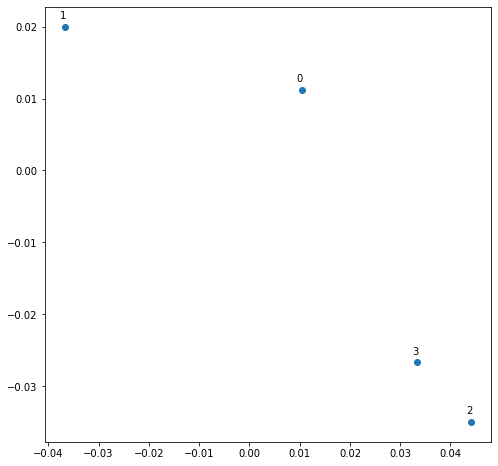

In [ ]:
plot_embed(model,'StateHoliday_Embed',pd.unique(df_train['StateHoliday']))

Como se analizo antes en el preprocesamiento:

- 0 = Ninguno
- 1 = festivo
- 2 = festivo de Pascua
- 3 = Navidad

Al ver el grafico, podemos notar que hay una gran diferencia de comportamiento entre los feriados y los días normales. A su vez difieren los días festivos de los días de Pascua y Navidad.

### Year_Embed

Son 3 grupos

(3, 3)


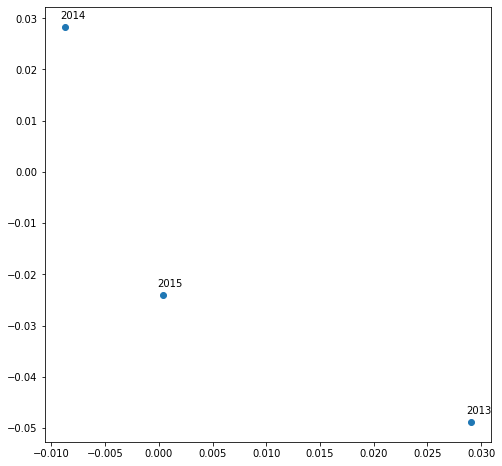

In [ ]:
plot_embed(model,'Year_Embed',[2015,2014,2013])

Como forman un triángulo, se puede deducir que hay un gran cambio en el comportamiento de los datos año a año.

### Month_Embed

Son 4 grupos

(12, 4)


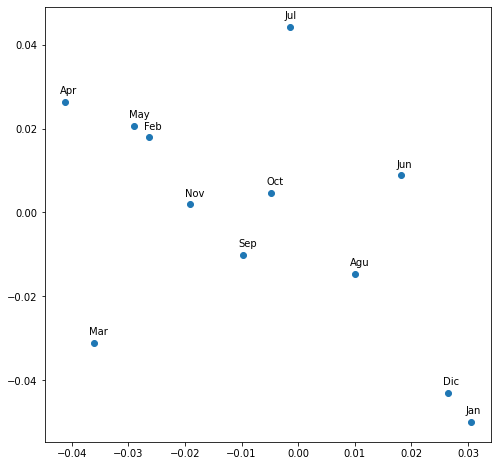

In [ ]:
plot_embed(model,'Month_Embed',['Jun','May','Apr','Mar','Feb','Jan','Dic','Nov','Oct','Sep','Agu','Jul'])

Los meses de verano pareciera que se comportan parecidos entre si, así como los de invierno. Se ve a los meses de vacaciones (Julio, Diciembre y Enero) separados del resto lo que indica que se comportan distinto, a su vez, también se diferencian claramente los meses de invierno (diciembre y enero) y los de verano (Julio).

### Day_Embed

Son 10 grupos

(31, 10)


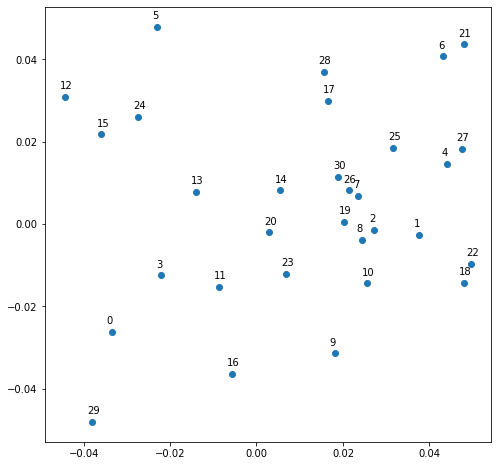

In [ ]:
plot_embed(model,'Day_Embed',np.unique(df['Day']))

### CompetitionMonthsOpen_Embed

son 4 grupos

(25, 4)


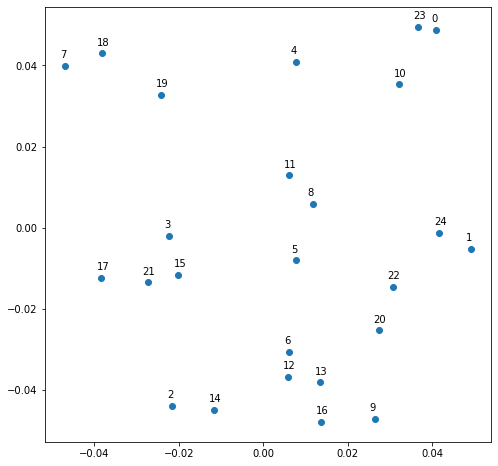

In [ ]:
plot_embed(model,'CompetitionMonthsOpen_Embed', np.unique(df['CompetitionMonthsOpen']))

Esta caracteristica la creamos en el preprocesamiento, especifica hace cuantos meses se abrio el competidor más cercano de la tienda. Se establecio el máximo de meses a evaluar, como 24.

Las tiendas no parecieran tener una diferencia de contexto según hace cuantos meses haya competidores cerca

### Promo2Weeks_Embed

Son 3 grupos

In [ ]:
# Valores que puede tomar la caracteristica antes de que se le haga en el Encode Label en el preprocesamiento
np.unique(df_train_bis['Promo2Weeks'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

(26, 3)


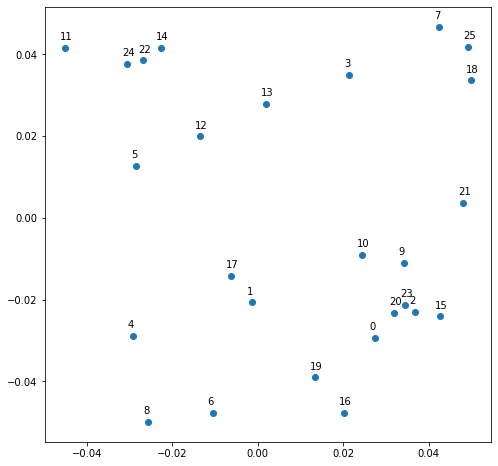

In [ ]:
plot_embed(model,'Promo2Weeks_Embed', np.unique(df['Promo2Weeks']))

En el preprocesamiento se agrego la caracteristica de hace cuantas semanas que la promo 2 esta vigente en la tienda. Sin embargo, pareciera ser que no hay un patron de comportamiento de las ventas en las tiendas según hace cuanto que esta la promoción 2.

### StoreType_Embed

Son 2 grupos

(4, 2)


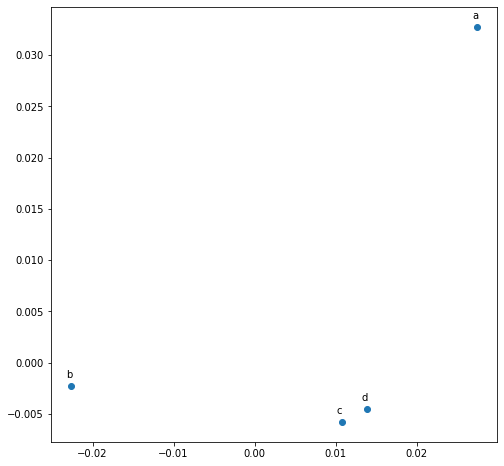

In [ ]:
plot_embed(model,'StoreType_Embed',['c','a','d','b'])

Vemos que los cuatro tipos de tienda tienen comportamientos bastante disimiles entre si, pero los tipos de tienda a en particular son los que tienen un comportamiento más distinto a los otros. Se ve que las tiendas c y d tienen un comportamiento parecido.

### Assortment_Embed

Son 3 grupos

(3, 3)


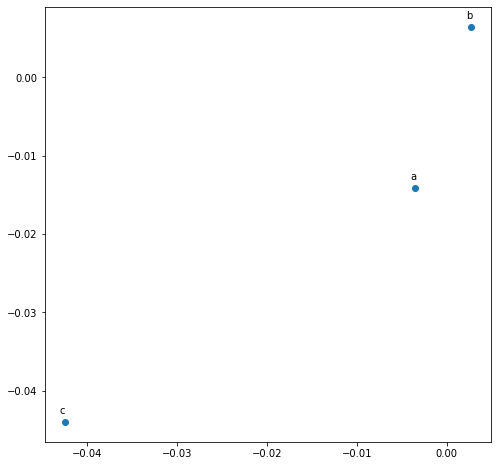

In [ ]:
plot_embed(model,'Assortment_Embed', ['a','b','c'])

Recordando que esta caracteristica define el nivel de surtido de la tienda: 

- a = basico
- b = extra
- c = extendido

Se ve que dependiendo el surtido de la tienda, esta va a tener diferentes comportamientos. Vemos además que el comportamiento de a (básico) se acerca al de b (extra). 

### PromoInterval_Embed

Son 3 grupos

(4, 3)


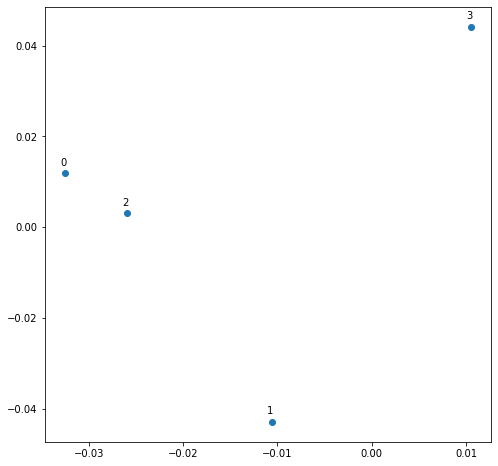

In [ ]:
plot_embed(model,'PromoInterval_Embed', np.unique(df['PromoInterval']))

describe los intervalos consecutivos en que se inicia Promo2, nombrando los meses en que la promoción se inicia de nuevo.

- 0 = _
- 1 = 'Feb,May,Aug,Nov'
- 2 = 'Jan,Apr,Jul,Oct'
- 3 = 'Mar,Jun,Sept,Dec'

Vemos que el en los que no hay un intervalo de promo dos se parece al que los intervalos de promo 2 son 'Jan,Apr,Jul,Oct'.

### CompetitionOpenSinceYear_Embed

Son 4 grupos

(21, 4)


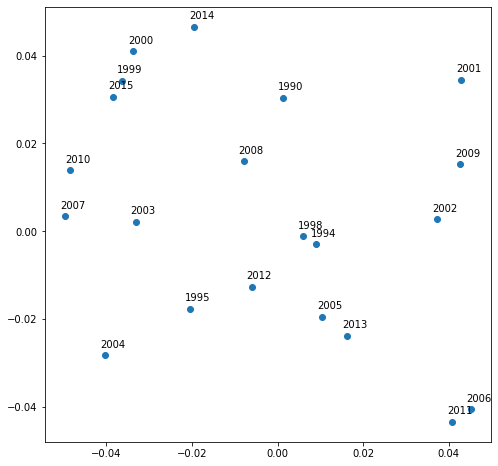

In [ ]:
plot_embed(model,'CompetitionOpenSinceYear_Embed', [1990,1994,1995,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015])

### Events_Embed

Son 7 grupos

(22, 7)


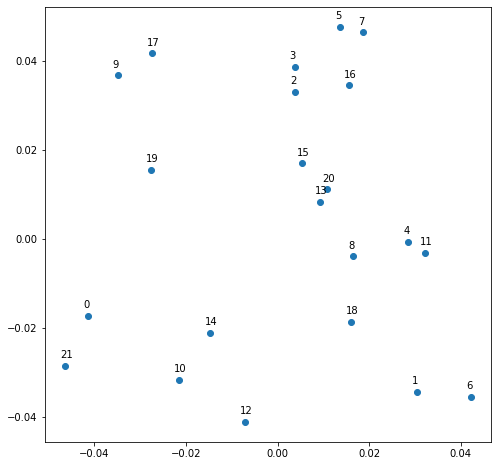

In [ ]:
plot_embed(model,'Events_Embed',np.unique(df['Events']))

- 'Fog': 0
- 'Fog-Rain': 1
- 'Fog-Rain-Hail': 2
- 'Fog-Rain-Hail-Thunderstorm': 3
- 'Fog-Rain-Snow': 4
- 'Fog-Rain-Snow-Hail': 5
- 'Fog-Rain-Thunderstorm': 6
- 'Fog-Snow': 7
- 'Fog-Snow-Hail': 8
- 'Fog-Thunderstorm': 9
- 'Rain': 10
- 'Rain-Hail': 11
- 'Rain-Hail-Thunderstorm': 12
- 'Rain-Snow': 13
- 'Rain-Snow-Hail': 14
- 'Rain-Snow-Hail-Thunderstorm': 15
- 'Rain-Snow-Thunderstorm': 16
- 'Rain-Thunderstorm': 17
- 'Snow': 18
- 'Snow-Hail': 19
- 'Sunny': 20
- 'Thunderstorm': 21

De acá concluimos que los eventos climaticos no pareciera tener ningún tipo efecto sobre el comportamiento de los datos de Ventas

### Close_bool_bw_Embed

Son 3 grupos

(7, 3)


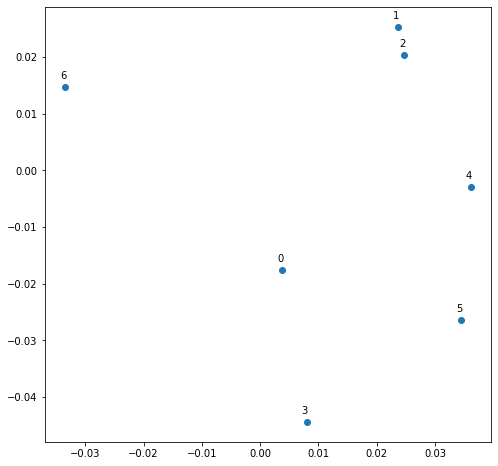

In [ ]:
plot_embed(model,'Close_bool_bw_Embed', np.unique(df['Close_bool_bw']))

Vemos que cuando tienen 6 dias antes del cierre se comportan son los que se comportan más distinto a los demás.

### Close_bool_fw_Embed

Son 3 grupos

(7, 3)


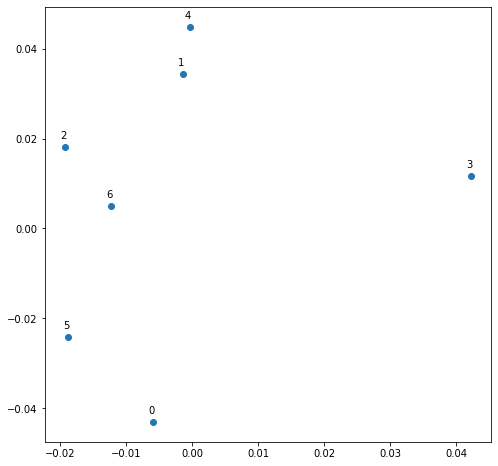

In [9]:
plot_embed(model,'Close_bool_fw_Embed', np.unique(df['Close_bool_fw']))

Aca vemos que 3 días despues tiene el comportamiento más distinto al resto. 